In [1]:
import sys
sys.path.append(sys.path[0] + '/deepkexpfam')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from flows import Flow_VI, ObjectDataset
from torch.utils.data import Dataset, DataLoader
from utils import plot_flow2D, plot_object2D, make_grid_data
from utils import load_object

from torch.distributions.multivariate_normal import MultivariateNormal
from Datasets import Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring

%matplotlib inline

In [3]:
# Spiral, Funnel, Ring, Grid, Banana, Uniform, Cosine, Multiring
d = 1
D = 2
layers = 20

sample_size = 5000
batch_size = 100
epochs = 300
lr = 0.001
weight_decay = 0

names = ['Funnel', 'Banana', 'Ring', 'Uniform', 'Cosine', 'Grid', 'Multiring']
objs = [Funnel(), Banana(), Ring(), Uniform(), Cosine(), Grid(), Multiring()]

x_interval, y_interval = np.linspace(-7, 7, 500), np.linspace(-7, 7, 500)

grid_x, grid_y, X = make_grid_data(x_interval, y_interval)
X = torch.from_numpy(X).float()

In [5]:
# small prior variance

def train(obj, prior_p):
    
    flow = Flow_VI(d, D, layers, coupling_layers='additive')

    optimizer = torch.optim.Adam(flow.cl.parameters(), lr=lr, weight_decay=weight_decay)
    dataset = ObjectDataset(obj, sample_size)
    loader = DataLoader(dataset , batch_size=batch_size , shuffle=True)

    
    for epoch in range(epochs):
        for X_batch in loader:
            flow.sample_params()

            mu_s = flow.cl.mu_s
            sigma_s = flow.cl.sigma_s
            s = flow.cl.s

            dist = MultivariateNormal(mu_s, torch.diag(sigma_s ** 2))
            log_q = dist.log_prob(s)

            dist = MultivariateNormal(torch.zeros_like(s), prior_p * torch.eye(len(s)))
            log_p = dist.log_prob(s)

            for j in range(len(flow.cl.MLP_list)):
                mlp = flow.cl.MLP_list[j]
                for k in range(len(mlp.mu_Ws)):
                    mu_W = mlp.mu_Ws[k].view(-1)
                    mu_b = mlp.mu_bs[k].view(-1)
                    sigma_W = mlp.sigma_Ws[k].view(-1)
                    sigma_b = mlp.sigma_bs[k].view(-1)
                    W = mlp.Ws[k].view(-1)
                    b = mlp.bs[k].view(-1)

                    dist = MultivariateNormal(mu_W, torch.diag(sigma_W ** 2))
                    log_q = log_q + dist.log_prob(W)

                    dist = MultivariateNormal(mu_b, torch.diag(sigma_b ** 2))
                    log_q = log_q + dist.log_prob(b)

                    dist = MultivariateNormal(torch.zeros_like(W), prior_p * torch.eye(len(W)))
                    log_p = log_p + dist.log_prob(W)

                    dist = MultivariateNormal(torch.zeros_like(b), prior_p * torch.eye(len(b)))
                    log_p = log_p + dist.log_prob(b)

            log_like = sample_size / batch_size * flow.log_data_likelihood(X_batch, with_grad=True)

            cost = log_q - log_p - log_like

            if torch.isnan(log_like) or torch.isinf(log_like):
                print('@@@', i, log_like, log_q)
                continue

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(epoch, log_q - log_p - log_like)
        
    return flow


prior_ps = [0.0001, 0.001, 1000, 10000]

flows = []
for i in range(len(names)):
    name = names[i]
    obj = objs[i]
    flow_priors = []
    for prior_p in prior_ps:
        print(name, prior_p)
        flow = train(obj, prior_p)
        flow_priors.append(flow)
    
    flows.append(flow_priors)

Ring 0.0001
0 tensor(1455613., grad_fn=<SubBackward0>)
10 tensor(691243.5000, grad_fn=<SubBackward0>)
20 tensor(381652.9688, grad_fn=<SubBackward0>)
30 tensor(226882.2812, grad_fn=<SubBackward0>)
40 tensor(210180.3438, grad_fn=<SubBackward0>)
50 tensor(148606.1719, grad_fn=<SubBackward0>)
60 tensor(115208.1562, grad_fn=<SubBackward0>)
70 tensor(195028.6250, grad_fn=<SubBackward0>)
80 tensor(102323.7812, grad_fn=<SubBackward0>)
90 tensor(108350.7344, grad_fn=<SubBackward0>)
Ring 0.001
0 tensor(181794.4375, grad_fn=<SubBackward0>)
10 tensor(187767.1250, grad_fn=<SubBackward0>)
20 tensor(716657.8750, grad_fn=<SubBackward0>)
30 tensor(177854.8906, grad_fn=<SubBackward0>)
40 tensor(1256846.6250, grad_fn=<SubBackward0>)
50 tensor(179348.4062, grad_fn=<SubBackward0>)
60 tensor(168440.1562, grad_fn=<SubBackward0>)
70 tensor(182326.3906, grad_fn=<SubBackward0>)
80 tensor(174999.8438, grad_fn=<SubBackward0>)
90 tensor(164013.1875, grad_fn=<SubBackward0>)
Ring 1000
0 tensor(97099.8516, grad_fn=<S

Ring
[0.0001, 0.001, 1000, 10000]


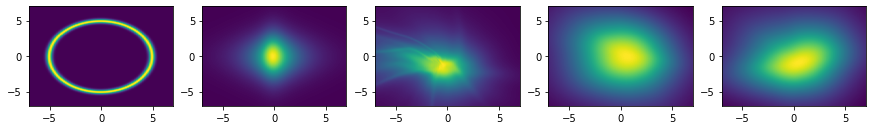

In [6]:
# Plot flows
n = 100

plt.figure(figsize=(15,15))
for i in range(len(names)):
    name = names[i]
    obj = objs[i]
    flow_priors = flows[i]
    n_priors = len(flow_priors)
    
    
    print(name)
    
    plt.subplot(7, n_priors+1, (n_priors+1)*i+1)
    plot_object2D(obj, x_interval, y_interval)
    
    for j in range(n_priors):
        flow = flow_priors[j]
        pX_all = np.zeros((n, 500, 500))
        for k in range(n):
            flow.sample_params()

            log_pX = flow.log_likelihood(X)
            pX = torch.exp(log_pX)
            pX[~pX.isfinite()] = 0. # Make -inf of nan values to have 0 density
            pX = pX.numpy().reshape(len(x_interval), len(y_interval))

            pX_all[k, :, :] = pX
    
        plt.subplot(7, n_priors+1, (n_priors+1)*i+j+2)
        plt.pcolormesh(grid_x, grid_y, pX_all.mean(axis=0), shading='auto')

print(prior_ps)

In [4]:
def map_params(flow_prev, flow_after, posterior_rho):
    for j in range(len(flow_prev.cl.MLP_list)):
        for k in range(len(flow_prev.cl.MLP_list[j].mu_Ws)):
            w = flow_after.cl.MLP_list[j].layers[k].state_dict()['weight'].T
            b = flow_after.cl.MLP_list[j].layers[k].state_dict()['bias']
            
            flow_prev.cl.MLP_list[j].mu_Ws[k] = torch.nn.Parameter(w)
            flow_prev.cl.MLP_list[j].mu_bs[k] = torch.nn.Parameter(b)
            #flow_prev.cl.MLP_list[j].rho_Ws[k] = torch.nn.Parameter(posterior_rho * torch.rand_like(w))
            #flow_prev.cl.MLP_list[j].rho_bs[k] = torch.nn.Parameter(posterior_rho * torch.rand_like(b))
            flow_prev.cl.MLP_list[j].rho_Ws[k] = torch.nn.Parameter(posterior_rho * torch.ones_like(w))
            flow_prev.cl.MLP_list[j].rho_bs[k] = torch.nn.Parameter(posterior_rho * torch.ones_like(b))
            
    
    s = flow_after.cl.s.detach()
    flow_prev.cl.mu_s = torch.nn.Parameter(s)
    #flow_prev.cl.rho_s = torch.nn.Parameter(posterior_rho * torch.rand_like(s))
    flow_prev.cl.rho_s = torch.nn.Parameter(posterior_rho * torch.ones_like(s))
    
    flow_prev.sample_params()

def find_empirical_var(flow):
    a = torch.tensor([])
    for param in flow.cl.parameters():
        a = torch.cat((param.data.view(-1), a))
    
    return a.var()
    

def param_map_train(obj, flow_map, posterior_rho):
    
    flow = Flow_VI(d, D, layers, coupling_layers='additive')
    
    map_params(flow, flow_map, posterior_rho)
    prior_var = find_empirical_var(flow_map)

    optimizer = torch.optim.Adam(flow.cl.parameters(), lr=lr, weight_decay=0)
    dataset = ObjectDataset(obj, sample_size)
    loader = DataLoader(dataset , batch_size=batch_size , shuffle=True)

    for epoch in range(epochs):
        for X_batch in loader:
            flow.sample_params()

            mu_s = flow.cl.mu_s
            sigma_s = flow.cl.sigma_s
            s = flow.cl.s

            dist = MultivariateNormal(mu_s, torch.diag(sigma_s ** 2))
            log_q = dist.log_prob(s)

            dist = MultivariateNormal(torch.zeros_like(s), prior_var * torch.eye(len(s)))
            log_p = dist.log_prob(s)

            for j in range(len(flow.cl.MLP_list)):
                mlp = flow.cl.MLP_list[j]
                for k in range(len(mlp.mu_Ws)):
                    mu_W = mlp.mu_Ws[k].reshape(-1)
                    mu_b = mlp.mu_bs[k].reshape(-1)
                    sigma_W = mlp.sigma_Ws[k].reshape(-1)
                    sigma_b = mlp.sigma_bs[k].reshape(-1)
                    W = mlp.Ws[k].reshape(-1)
                    b = mlp.bs[k].reshape(-1)

                    dist = MultivariateNormal(mu_W, torch.diag(sigma_W ** 2))
                    log_q = log_q + dist.log_prob(W)

                    dist = MultivariateNormal(mu_b, torch.diag(sigma_b ** 2))
                    log_q = log_q + dist.log_prob(b)

                    dist = MultivariateNormal(torch.zeros_like(W), prior_var * torch.eye(len(W)))
                    log_p = log_p + dist.log_prob(W)

                    dist = MultivariateNormal(torch.zeros_like(b), prior_var * torch.eye(len(b)))
                    log_p = log_p + dist.log_prob(b)

            log_like = sample_size / batch_size * flow.log_data_likelihood(X_batch, with_grad=True)

            cost = log_q - log_p - log_like

            if torch.isnan(log_like) or torch.isinf(log_like):
                print('@@@', i, log_like, log_q)
                continue

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(epoch, log_q - log_p - log_like)
        
    return flow

In [5]:
# initialise params, small posterior variance
posterior_rho = -5

save_path = './saved_flows_additive_limit_data/'

member_id = 0
flows = []
for i in range(len(names)):
    name = names[i]
    obj = objs[i]
    
    flow_map = load_object(save_path+name+str(member_id))
    flow = param_map_train(obj, flow_map, posterior_rho=posterior_rho)
    flows.append(flow)
    
    print(name)

0 tensor(26654.0156, grad_fn=<SubBackward0>)
10 tensor(26008.7695, grad_fn=<SubBackward0>)
20 tensor(25063.2422, grad_fn=<SubBackward0>)
30 tensor(23903.6445, grad_fn=<SubBackward0>)
40 tensor(23320.1973, grad_fn=<SubBackward0>)
50 tensor(22074.1348, grad_fn=<SubBackward0>)
60 tensor(22342.5625, grad_fn=<SubBackward0>)
70 tensor(20124.3691, grad_fn=<SubBackward0>)
80 tensor(20281.1562, grad_fn=<SubBackward0>)
90 tensor(20046.3633, grad_fn=<SubBackward0>)
100 tensor(19287.5195, grad_fn=<SubBackward0>)
110 tensor(18493.9043, grad_fn=<SubBackward0>)
120 tensor(19110.4766, grad_fn=<SubBackward0>)
130 tensor(20038.0703, grad_fn=<SubBackward0>)
140 tensor(18695.5781, grad_fn=<SubBackward0>)
150 tensor(20074.1289, grad_fn=<SubBackward0>)
160 tensor(18403.6133, grad_fn=<SubBackward0>)
170 tensor(19070.7559, grad_fn=<SubBackward0>)
180 tensor(20192.0527, grad_fn=<SubBackward0>)
190 tensor(19121.5000, grad_fn=<SubBackward0>)
200 tensor(18862.8906, grad_fn=<SubBackward0>)
210 tensor(18776.0801, g

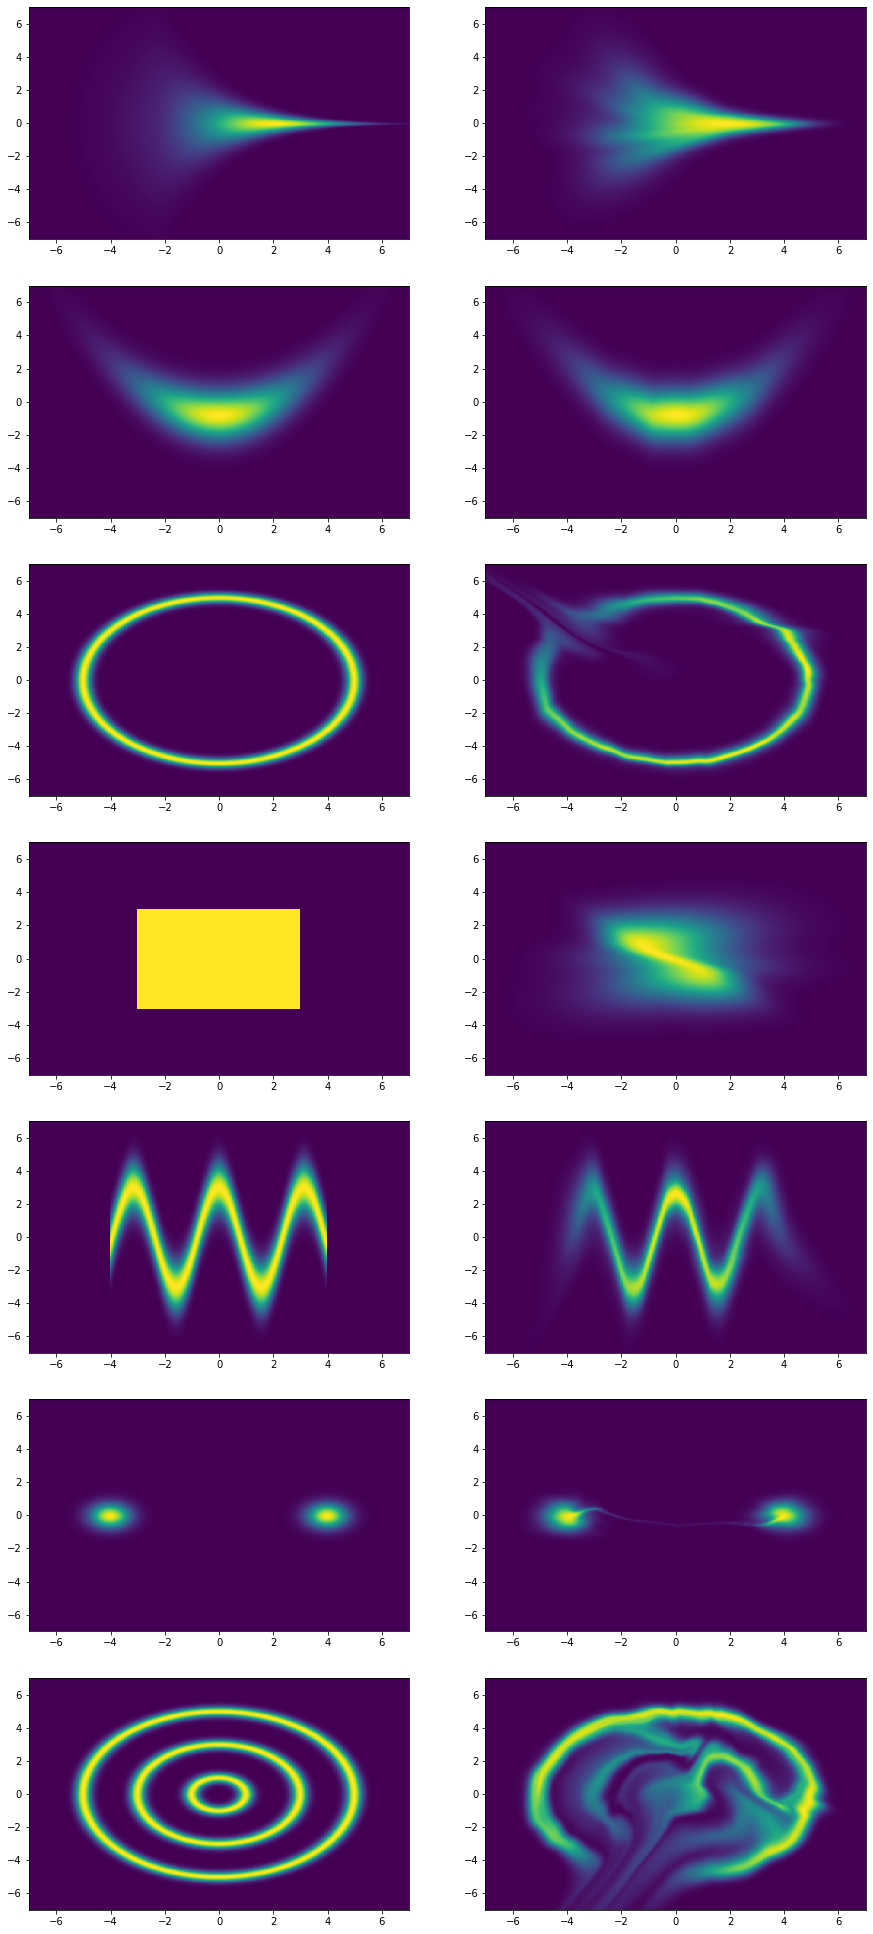

In [6]:
# Plot
n = 100
plt.figure(figsize=(15, 35))
for i in range(len(names)):
    name = names[i]
    obj = objs[i]
    flow = flows[i]
    
    pX_all = np.zeros((n, 500, 500))
    for k in range(n):
        flow.sample_params()

        log_pX = flow.log_likelihood(X)
        pX = torch.exp(log_pX)
        pX[~pX.isfinite()] = 0. # Make -inf of nan values to have 0 density
        pX = pX.numpy().reshape(len(x_interval), len(y_interval))

        pX_all[k, :, :] = pX

    
    plt.subplot(7, 2, 2*i+1)
    plot_object2D(obj, x_interval, y_interval)
    plt.subplot(7, 2, 2*i+2)
    plt.pcolormesh(grid_x, grid_y, pX_all.mean(axis=0), shading='auto')

In [9]:
torch.__version__

'1.9.0'